# Quantum Reservoir Computing with an Enhanced 2-Qubit Reservoir  
### Learning an Oscillatory Linear Recurrence

We now study a **more challenging recurrence**, with oscillatory and potentially unstable behaviour:

$$
y(t+1) = \alpha\,y(t) + \beta\,y(t-1),
\qquad
y(0) = A,\quad y(1)=B,
$$

with  
- $\alpha = 1.20$  
- $\beta = -0.85$  
- $A = 7.0$, $B = 4.5$.

This creates a dynamic sequence with strong oscillations, sign changes, and non-trivial temporal structure.

---

## Why this example is interesting?

Compared to the previous simple recurrence:

- the amplitude is larger  
- the oscillations persist longer  
- the system is closer to instability  
- the QRC must store **more temporal information**  
- a simple controlled-$R_y(\phi)$ gate is not expressive enough

To address this, we upgrade the reservoir to include:

- a **controlled–$R_y(\phi)$** gate on the memory qubit, and  
- a **local memory rotation $R_x(\theta)$** per time step  
- a **2D hyperparameter grid search** over $(\phi,\theta)$  

This makes the quantum memory more expressive and capable of handling oscillatory behaviour.

---


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import sys
from pathlib import Path

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
sys.path.append(str(ROOT / "src"))

from ar2 import *  
from normalization import *
from plotting import *
from qrc_model import *
from training import *


In [ ]:
alpha = 1.0       
beta  = -0.95

A = 1.0                       
B = 0.5                        

T_TOTAL = 80
T_TRAIN = 20
LAMBDA  = 1e-2

print(f"Recurrence: y(t+1) = {alpha:.4f} * y(t) + {beta:.4f} * y(t-1)")
print(f"Initial conditions: y(0)={A}, y(1)={B}")
print(f"Training window: 0..{T_TRAIN}, total horizon: {T_TOTAL}")


Recurrence: y(t+1) = 1.0000 * y(t) + -0.9500 * y(t-1)
Initial conditions: y(0)=1.0, y(1)=0.5
Training window: 0..20, total horizon: 80


In [ ]:
t_all = np.arange(0, T_TOTAL + 1)
y_all = generate_linear_series(alpha, beta, A, B, T_TOTAL)

print("First few raw values:", np.round(y_all[:8], 4))

First few raw values: [ 1.      0.5    -0.45   -0.925  -0.4975  0.3812  0.8539  0.4917]


## 1. Normalization for quantum encoding

The QRC encodes a scalar input $y(t)$ as a qubit amplitude:

$$
\ket{\psi(y)} = \sqrt{1-y}\ket{0} + \sqrt{y}\ket{1}.
$$

Therefore the input must lie in the interval $[0,1]$.

We map the raw time series to:

$$
y_{\text{norm}}(t) = \frac{y(t) - y_{\min}}{y_{\max} - y_{\min}},
$$

and later convert predictions back using the inverse map.


### Normalisation strategies

We compare three ways to map the raw series $y(t)$ to $[0,1]$ in order to
encode it into the quantum reservoir.

All use the affine map
$
y_{\mathrm{norm}}(t) = \frac{y(t)-y_{\min}}{y_{\max}-y_{\min}},
\qquad
y(t) = y_{\mathrm{norm}}(t)\,(y_{\max}-y_{\min}) + y_{\min},
$
but with different choices of $(y_{\min},y_{\max})$:

1. **Train-only range**: $[y_{\min}^{\text{train}}, y_{\max}^{\text{train}}]$.
2. **Full-series range**: $[y_{\min}^{\text{all}}, y_{\max}^{\text{all}}]$.
3. **Large a-priori range**: enlarged interval around the train range.

Each cell below redefines `norm_y`, `denorm_y` and `y_norm_all`.  
Choose one variant, run it, then run the rest of the notebook (training + plots).


In [ ]:
NORMALIZATION_METHOD = "enlarged"    
MARGIN_FACTOR = 1            

scaler = make_minmax_normalizer(
    method=NORMALIZATION_METHOD,
    y_all=y_all,
    T_TRAIN=T_TRAIN,
    margin_factor=MARGIN_FACTOR,
    clip=None,
)

print(f"Normalization method: {NORMALIZATION_METHOD}")
print("y_min =", scaler.y_min, ", y_max =", scaler.y_max)

y_norm_all = scaler.transform(y_all)

print("First normalized values:", np.round(y_norm_all[:8], 4))
print("min(y_norm_all) =", y_norm_all.min(), ", max(y_norm_all) =", y_norm_all.max())


Normalization method: enlarged
y_min = -2.8499999999999996 , y_max = 2.925
First normalized values: [0.6667 0.5801 0.4156 0.3333 0.4074 0.5595 0.6414 0.5786]
min(y_norm_all) = 0.3333333333333333 , max(y_norm_all) = 0.6666666666666666


## 2. Enhanced 2-qubit quantum reservoir

We use two qubits:

- **Input qubit** $I$ (reinitialized at each step)
- **Memory qubit** $M$ (carries temporal information)

Encoding of $y \in [0,1]$:

$$
\rho_I(y) = \ket{\psi(y)}\bra{\psi(y)}.
$$

The reservoir unitary is richer than before:

1. A **controlled–$R_y(\phi)$** gate:
   $$
   U_{CR_y}(\phi)
   = |0\rangle\langle 0|\otimes I
   + |1\rangle\langle 1|\otimes R_y(\phi),
   $$

2. A **local rotation $R_x(\theta)$** on the memory:
   $$
   U_{\text{local}} = I \otimes R_x(\theta).
   $$

The full reservoir evolution is:

$$
U(\phi,\theta) = U_{CR_y}(\phi)\; (I \otimes R_x(\theta)).
$$

This extra degree of freedom $\theta$ greatly increases expressivity,
which is necessary for oscillatory dynamics.


In [5]:
print("QRC primitives for (phi, theta) reservoir loaded.")

QRC primitives for (phi, theta) reservoir loaded.


## 3. One reservoir step and feature extraction

For normalized input $y_{\text{in}}(t)$ and memory state $\rho_M(t)$,
a QRC step performs:

1. Encode $y_{\text{in}} \rightarrow \rho_I$  
2. Build joint state $\rho_{IM} = \rho_I \otimes \rho_M$  
3. Apply reservoir unitary $U(\phi,\theta)$  
4. Update memory:  
   $$
   \rho_M(t+1) = \mathrm{Tr}_I\!\big[\rho_{\text{res}}(t)\big]
   $$
5. Measure features:
   $$
   x(t) = \bigl(\langle X_I\rangle,\langle Z_I\rangle,
                \langle X_M\rangle,\langle Z_M\rangle\bigr)
   $$

A second function applies the linear readout  
$$
y_{\text{hat}}(t+1) = W^\top x(t).
$$


In [ ]:
qrc_step_features = qrc_step_features_two_angles
qrc_step_with_readout = qrc_step_with_readout_two_angles

print("Loaded two-angle QRC step (phi, theta).")


Loaded two-angle QRC step (phi, theta).


## 4. Training the readout using teacher forcing

On the training window $t = 0, \dots, T_{\text{train}}-1$:

- Input to the reservoir: **true normalized values**
- Target: next value $y_{\text{norm}}(t+1)$

We form a design matrix:

$$
X = \begin{bmatrix}
x(0)^\top \\ x(1)^\top \\ \vdots \\ x(T_{\text{train}}-1)^\top
\end{bmatrix},
\qquad
\mathbf{y} = 
\begin{bmatrix}
y(1) \\ y(2) \\ \vdots \\ y(T_{\text{train}})
\end{bmatrix}.
$$

The readout is obtained by ridge regression:

$$
W^\star(\phi,\theta)
= \bigl(X^\top X + \lambda I \bigr)^{-1} X^\top \mathbf{y}.
$$


In [ ]:
t0 = 0
t1 = T_TRAIN   

phi=0
theta=0

X_train, y_train, W, L = build_design_matrix_two_angles(
    phi=phi,
    theta=theta,
    y_norm_series=y_norm_all,
    t_start=t0,
    t_end=t1,
    lam=LAMBDA,
)

print("Training design matrix shape:", X_train.shape)
print("Training MSE (normalized)   :", L)
print("Readout weights W           :", np.round(W, 6))


Training design matrix shape: (20, 4)
Training MSE (normalized)   : 0.006379067046078992
Readout weights W           : [ 0.185861 -0.233778  0.        0.30963 ]


## 5. Grid search over $(\phi,\theta)$

To find the best reservoir configuration, we scan:

- $\phi \in [0,2\pi]$
- $\theta \in [0,2\pi]$

For each pair, we:

1. Run teacher-forcing on the training window
2. Build the design matrix
3. Train $W$
4. Record the training loss

The best pair $(\phi^\star,\theta^\star)$ is selected.


In [8]:
phis   = np.linspace(0, 2 * np.pi, 40)
thetas = np.linspace(0, 2 * np.pi, 40)

print("Scanning hyperparameters...")

phi_star, theta_star, W_star, best_L = scan_phi_theta_grid(
    phis=phis,
    thetas=thetas,
    y_norm_series=y_norm_all,
    t_start=0,
    t_end=T_TRAIN,
    lam=LAMBDA,
)

print("\nBest parameters:")
print("phi*   =", phi_star)
print("theta* =", theta_star)
print("Min training loss =", best_L)
print("W* =", W_star)


Scanning hyperparameters...

Best parameters:
phi*   = 5.638756044904756
theta* = 5.316541413767342
Min training loss = 0.00014055004481370743
W* = [-0.5396022   0.0471004   0.03745091  0.19660008]


## 6. Autoregressive prediction

After training:

1. We replay the training window (teacher forcing) to initialize the memory.  
2. For $t \ge T_{\text{train}}$, we use **only the model predictions**:

$$
y_{\text{in}}(t) = y_{\text{hat}}(t),
\qquad
y_{\text{hat}}(t+1) = W^\star x(t).
$$

In [ ]:

rho_M = warmup_memory_two_angles(
    phi=phi_star,
    theta=theta_star,
    W=W_star,
    y_norm_series=y_norm_all,
    t_start=0,
    t_end=T_TRAIN,
)

t_start_pred = T_TRAIN
t_end_pred   = T_TOTAL

t_pred, y_pred_norm = autoregressive_rollout_two_angles(
    phi=phi_star,
    theta=theta_star,
    W=W_star,
    y_norm_series=y_norm_all,
    t_start_pred=t_start_pred,
    t_end_pred=t_end_pred,
    rho_M_init=rho_M,
    clip=True,           
)

y_pred_raw = scaler.inverse_transform(y_pred_norm)

y_true_test = y_all[t_pred]
abs_err = np.abs(y_pred_raw - y_true_test)
rel_err = abs_err / np.maximum(np.abs(y_true_test), 1e-12)

print("Mean ABS error:", abs_err.mean())
print("Mean REL error:", rel_err.mean())


Mean ABS error: 0.08805319699714319
Mean REL error: 1.6568068237061437


## 7. Results: true vs QRC predictions

We compare:

- the true oscillatory recurrence  
- the training window (teacher-forcing)  
- the autoregressive quantum predictions  


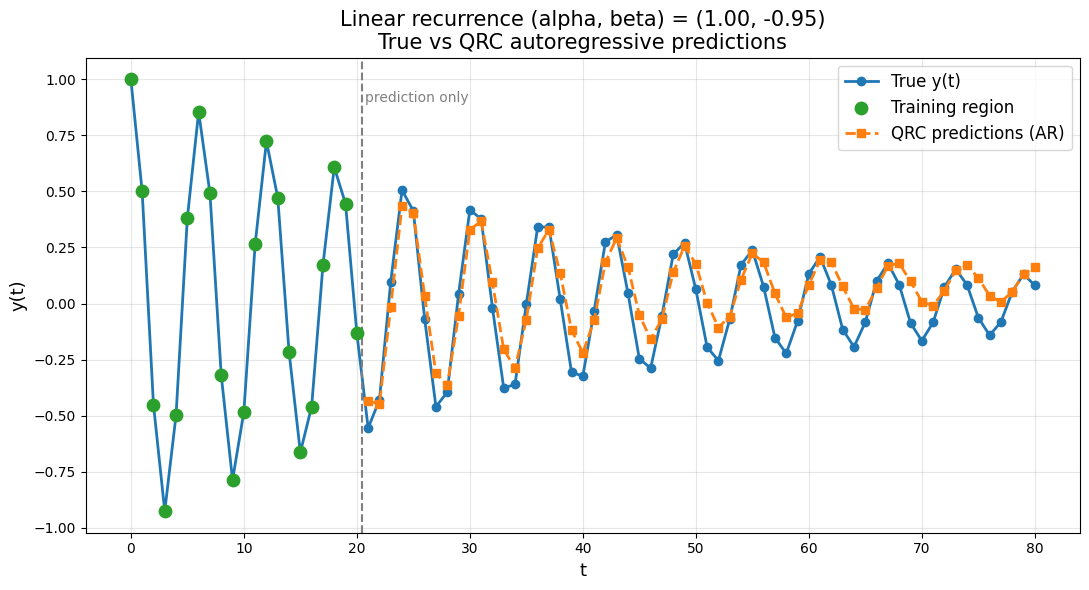

In [10]:
plot_true_vs_qrc_predictions(
    t_all=t_all,
    y_all=y_all,
    t_start_train=0,
    t_end_train=T_TRAIN,
    t_pred=t_pred,
    y_pred_raw=y_pred_raw,
    t_start_pred=T_TRAIN,
    alpha=alpha,
    beta=beta,
)

### Final comparison: impact of reservoir angle selection on predictive performance

The grid search introduced above allows us to identify angle pairs $(\phi,\theta)$ that minimize the
training loss of the two-angle quantum reservoir. However, a low training error alone does not
fully characterize the quality of the learned dynamics, especially in the **autoregressive regime**.

To better assess the practical impact of the reservoir parametrization, we conclude this section
with a **side-by-side comparison of three representative configurations**:

- **Baseline**: $(\phi,\theta) = (0,0)$, corresponding to a minimal reservoir (the identity) with no internal mixing.
  This case serves as a reference and highlights the limitations of poorly structured internal dynamics.

- **Decent (non-optimal)**: an angle pair selected among the good, but not optimal, solutions of the grid
  search (e.g., the $K$-th best configuration). This illustrates that a broad region of parameter space
  already yields reasonable performance.

- **Optimal**: the angle pair $(\phi^\star,\theta^\star)$ that minimizes the training loss on the grid.
  This configuration represents the best internal dynamics achievable within the explored parameter range.

For each case, the readout is trained using teacher forcing on the same training window, after which
the system is run **fully autonomously** on the test interval. The figure below shows the resulting
closed-loop predictions in raw space, allowing for a direct comparison of stability and amplitude
preservation across different reservoir parametrizations.


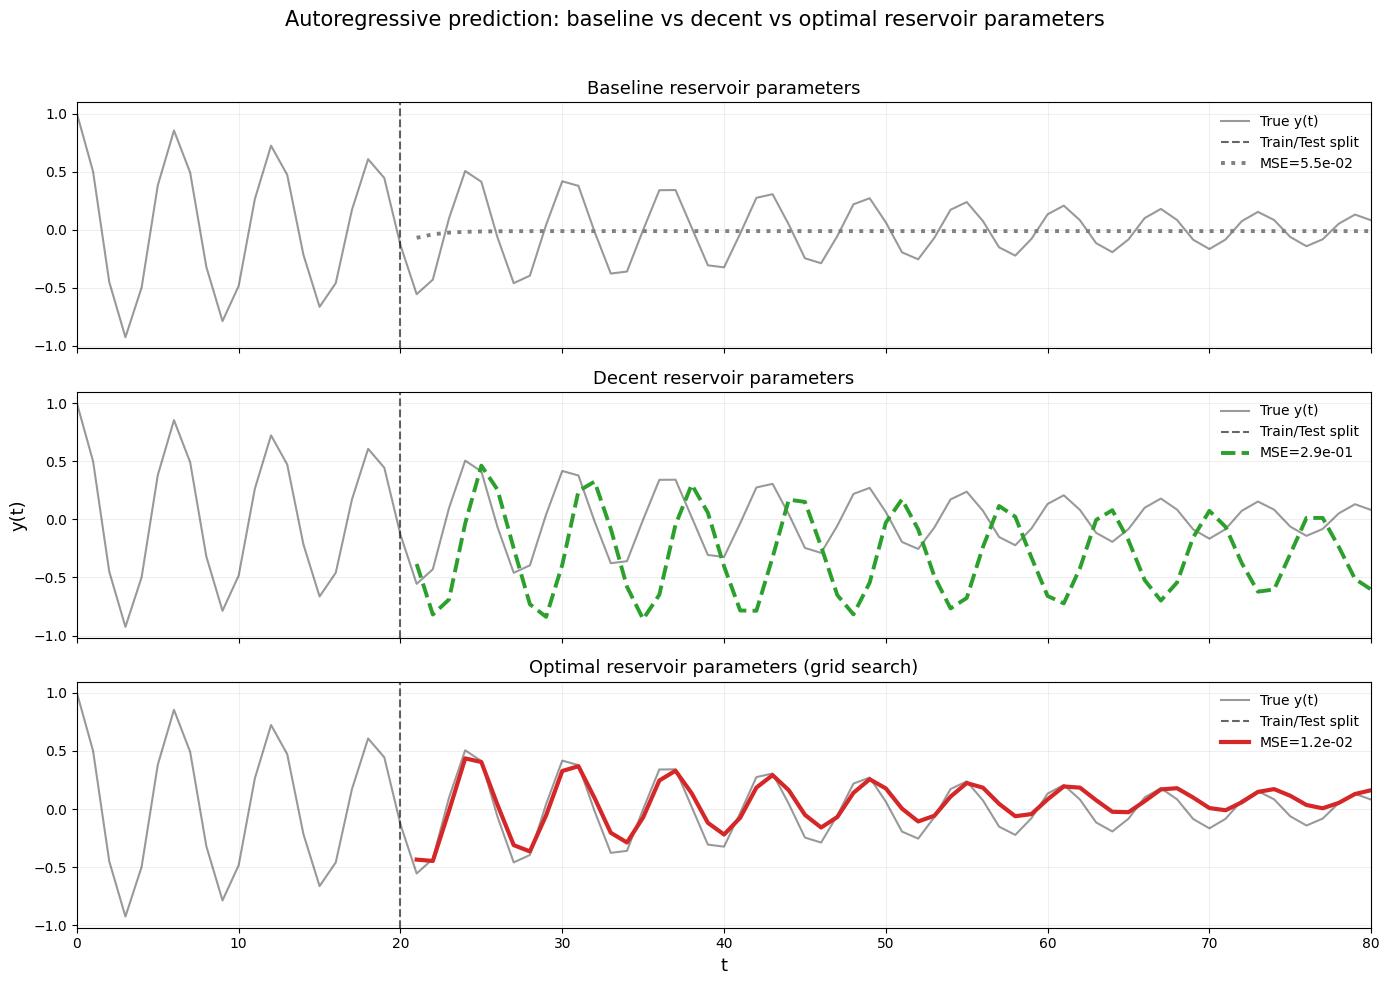

In [11]:
results = run_baseline_decent_best_two_angles(
    y_norm_all=y_norm_all,
    y_all=y_all,
    scaler=scaler,
    T_TRAIN=T_TRAIN,
    T_TOTAL=T_TOTAL,
    lam=LAMBDA,
    phis=phis,
    thetas=thetas,
    K=30,
    clip=True,
)

plot_three_panel_qrc(
    t_all=t_all,
    y_all=y_all,
    T_TRAIN=T_TRAIN,
    T_TOTAL=T_TOTAL,
    case_00=results["case_00"],
    case_decent=results["case_decent"],
    case_star=results["case_star"],
)


### Training-loss landscape over the reservoir parameter grid

The grid search performed above returns a single optimal pair $(\phi^*, \theta^*)$, but it is often
useful to visualize the **entire optimization landscape** to understand how sensitive the model is to
the choice of internal angles.

In the following, we compute the training loss $\mathcal{L}(\phi,\theta)$ on the **same discretized grid**
used in the search, and represent it as:

- a **heatmap** of $\log_{10}\mathcal{L}(\phi,\theta)$, which highlights the best regions even when the loss
  spans several orders of magnitude;
- an optional **contour view** that helps reveal the geometry of valleys / plateaus.

We overlay three reference configurations on the landscape:
- the **baseline** $(0,0)$,
- the **optimal** pair $(\phi^*,\theta^*)$ (argmin on the grid),
- a **suboptimal but decent** pair selected among the top configurations (e.g., the $K$-th best).

This provides a compact visual summary of (i) how structured the good region is, and (ii) whether good
performance requires a very fine tuning of the reservoir angles or remains robust across a broader range
of parameters.


Best from landscape:
phi*   = 5.6388
theta* = 5.3165
L_min  = 1.405500e-04


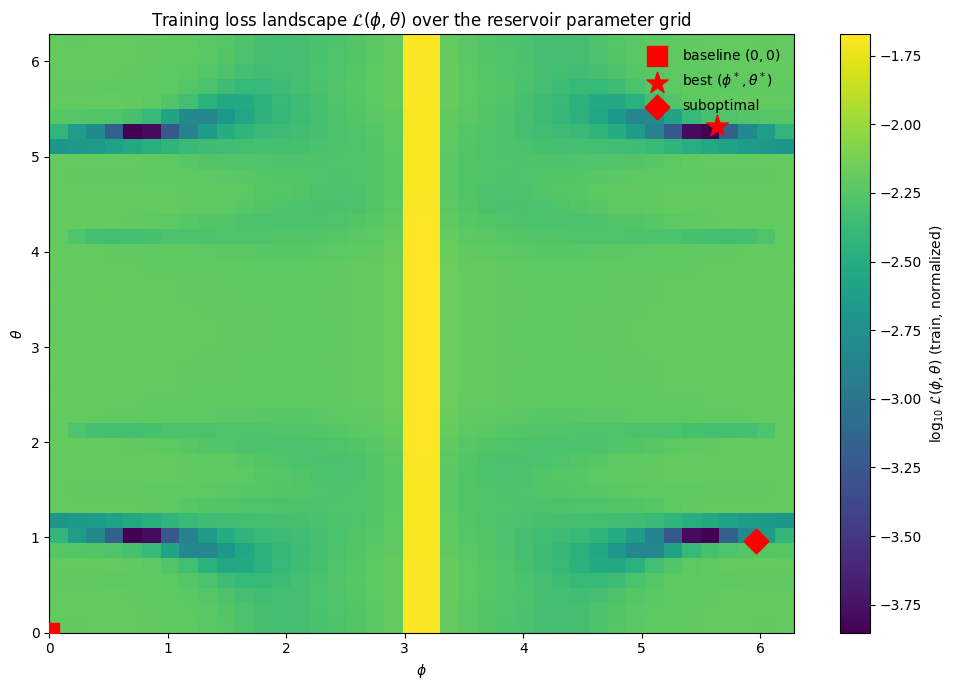

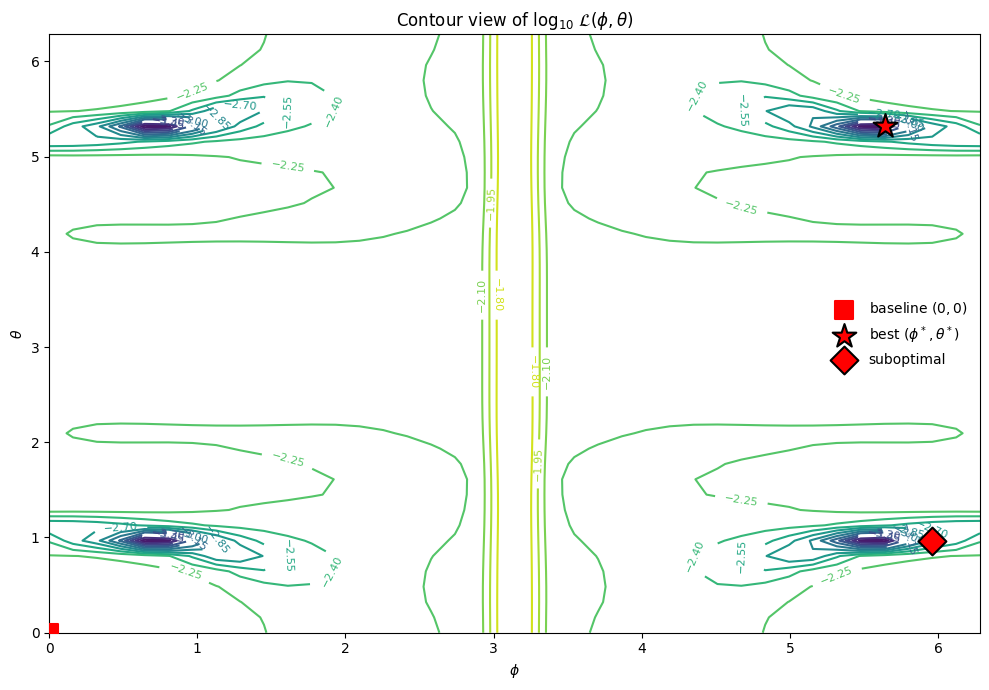

In [12]:
L_grid = grid_search_two_angles_losses(
    phis=phis, thetas=thetas,
    y_norm_all=y_norm_all,
    T_TRAIN=T_TRAIN,
    lam=LAMBDA,
)

(phi_star_land, theta_star_land, best_L) = (
    float(phis[np.argmin(L_grid) % len(phis)]),
    float(thetas[np.argmin(L_grid) // len(phis)]),
    float(np.min(L_grid)),
)

phi_decent, theta_decent = pick_kth_best_from_grid(L_grid, phis, thetas, K=30)

print("Best from landscape:")
print(f"phi*   = {phi_star_land:.4f}")
print(f"theta* = {theta_star_land:.4f}")
print(f"L_min  = {best_L:.6e}")

plot_loss_landscape_two_angles(
    phis=phis,
    thetas=thetas,
    L_grid=L_grid,
    phi_star=phi_star_land,
    theta_star=theta_star_land,
    phi_decent=phi_decent,
    theta_decent=theta_decent,
    show_contours=True,
)